# QC protocol for Private Weather Stations

This notebook presents how to use the Python package `pypwsqc`, a quality assurance protocol developed for automated private weather stations (PWS). The protocol consists of three filters; the Faulty Zero filter, the High Influx filter and the Station Outlier filter.

The package is based on the original R code available at https://github.com/LottedeVos/PWSQC/.

Publication: de Vos, L. W., Leijnse, H., Overeem, A., & Uijlenhoet, R. (2019). Quality control for crowdsourced personal weather stations to enable operational rainfall monitoring. Geophysical Research Letters, 46(15), 8820-8829

`pypwsqc` depends on the `poligrain`, `xarray` and `numpy` packages. Make sure to install and import the required packages first.

In [1]:
import matplotlib.pyplot as plt
import poligrain as plg
import xarray as xr

import pypwsqc

## Download example data

In this example, we use an open PWS dataset from Amsterdam, called the "AMS PWS" dataset. By running the cell below, an example NetCDF-file will be downloaded to your current repository (if your machine is connected to the internet).

In [2]:
!curl -OL https://github.com/OpenSenseAction/OS_data_format_conventions/raw/main/notebooks/data/OpenSense_PWS_example_format_data.nc

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
curl: (35) schannel: next InitializeSecurityContext failed: CRYPT_E_NO_REVOCATION_CHECK (0x80092012) - Återkallningsfunktionen kunde inte göra en återkallningskontroll för certifikatet.


## Data preparations

This package handles rainfall data as `xarray`  Datasets. The data set must have `time` and `id` dimensions, `latitude` and `longitude` as coordinates, and `rainfall` as data variable.

An example of how to convert .csv data to a `xarray` dataset is found [here](https://github.com/OpenSenseAction/OS_data_format_conventions/blob/main/notebooks/PWS_example_dataset.ipynb).

In [3]:
ds_pws = xr.open_dataset("OpenSense_PWS_example_format_data.nc")
ds_pws

<xarray.Dataset>
Dimensions:    (time: 219168, id: 134)
Coordinates:
  * time       (time) datetime64[ns] 2016-05-01T00:05:00 ... 2018-06-01
  * id         (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation  (id) <U3 ...
    latitude   (id) float64 ...
    longitude  (id) float64 ...
Data variables:
    rainfall   (id, time) float64 ...
Attributes:
    title:                 PWS data from Amsterdam
    file author:           Maximilian Graf
    institution:           Wageningen University and Research, Department of ...
    date:                  2022-10-18 10:32:00
    source:                Netamo PWS
    history:               Data derived and reformated from the originally pu...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

### Reproject coordinates 

First we reproject the coordinates to a local metric coordinate reference system to allow for distance calculations. In the Amsterdam example we use EPSG:25832. **Remember to use a local metric reference system for your use case!** We use the function `spatial.project_point_coordinates` in the `poligrain`package. 

In [4]:
ds_pws.coords["x"], ds_pws.coords["y"] = plg.spatial.project_point_coordinates(
    x=ds_pws.longitude, y=ds_pws.latitude, target_projection="EPSG:25832"
)

### Create distance matrix

Then, we calculate the distances between all stations in our data set. If your data set has a large number of stations this can take some time.

In [5]:
distance_matrix = plg.spatial.calc_point_to_point_distances(ds_pws, ds_pws)

### Calculate data variables 

Next, we will calculate the data variables `nbrs_not_nan` and `reference` that are needed to perform the quality control.

`nbrs_not_nan`:
Number of neighbours within a specificed range `max_distance` around the station that are reporting rainfall for each time step. The selected range depends on the use case and area of interest. In this example we use 10'000 meters. 

 `reference`:
Median rainfall of all stations within range `max_distance` from each station.

#### Select `max_distance`, considered range around each station

In [6]:
max_distance = 10e3

In [7]:
%%time
ds_pws = ds_pws.load()

nbrs_not_nan = []
reference = []

for pws_id in ds_pws.id.data:
    neighbor_ids = distance_matrix.id.data[
        (distance_matrix.sel(id=pws_id) < max_distance)
        & (distance_matrix.sel(id=pws_id) > 0)
    ]

    N = ds_pws.rainfall.sel(id=neighbor_ids).isnull().sum(dim="id")
    nbrs_not_nan.append(N)

    median = ds_pws.sel(id=neighbor_ids).rainfall.median(dim="id")
    reference.append(median)

ds_pws["nbrs_not_nan"] = xr.concat(nbrs_not_nan, dim="id")
ds_pws["reference"] = xr.concat(reference, dim="id")

CPU times: total: 1min 42s
Wall time: 1min 43s


In [8]:
ds_pws

<xarray.Dataset>
Dimensions:       (time: 219168, id: 134)
Coordinates:
  * time          (time) datetime64[ns] 2016-05-01T00:05:00 ... 2018-06-01
  * id            (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation     (id) <U3 'nan' 'nan' 'nan' 'nan' ... 'nan' 'nan' 'nan' 'nan'
    latitude      (id) float64 52.31 52.3 52.31 52.35 ... 52.31 52.43 52.3 52.26
    longitude     (id) float64 4.671 4.675 4.677 4.678 ... 5.036 5.041 5.045
    x             (id) float64 2.049e+05 2.052e+05 ... 2.301e+05 2.301e+05
    y             (id) float64 5.804e+06 5.803e+06 ... 5.802e+06 5.798e+06
Data variables:
    rainfall      (id, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 nan 0.0 0.0 0.0
    nbrs_not_nan  (id, time) int32 8 8 8 8 8 8 8 8 8 8 ... 10 9 10 9 9 9 9 9 9
    reference     (id, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    title:                 PWS data from Amsterdam
    file author:           Maximilian Graf
    institution:           Wageningen University and Research, Department of ...
    date:                  2022-10-18 10:32:00
    source:                Netamo PWS
    history:               Data derived and reformated from the originally pu...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

## Quality control

Now the data set is prepared to run the quality control.

### Apply Faulty Zero filter

Conditions for raising Faulty Zeros flag:

* Median rainfall of neighbouring stations within range `max_distance` is larger than zero for at least `nint` time intervals while the station itself reports zero rainfall.
* The FZ flag remains 1 until the station reports nonzero rainfall.
* Filter cannot be applied if less than `nstat` neighbours are reporting data (FZ flag is set to -1)

For settings for parameter `nint` and `nstat`, see table 1 in https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL083731

In [9]:
fz_flag = pypwsqc.flagging.fz_filter(
    pws_data=ds_pws.rainfall,
    nbrs_not_nan=ds_pws.nbrs_not_nan,
    reference=ds_pws.reference,
    nint=3,
    n_stat=5,
)

#### Add FZ flags to data set

In [10]:
ds_pws["fz_flag"] = fz_flag

## Inspect some results 

All stations have FZ flags the first `nint` timesteps as the filter conditions cannot be evaulated the first `nint` timesteps. Let's look at station ams77 who get a lot of FZ-flags throughout the evaluation period

Text(0.5, 1.0, 'Faulty Zero flags, ams77')

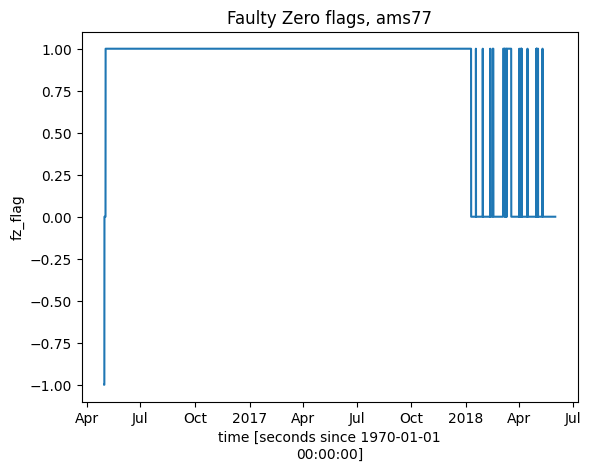

In [11]:
stations = "ams77"
plt.figure()
ds_pws.fz_flag.sel(id="ams77").plot.line(x="time", add_legend=True)
# plt.title('Faulty Zero flags', str(ds_pws.id.sel(id = 'ams77').data))
plt.title("Faulty Zero flags, " + str(ds_pws.id.sel(id=stations).data))

We can suspect that this stations has incomplete time series. Indeed, when inspecting the rainfall data from ams77 we see that the station records very little rain throughout the evaluation period and seems to be improperly installed and/or maintained. 

Text(0.5, 1.0, 'Rainfall, ams77')

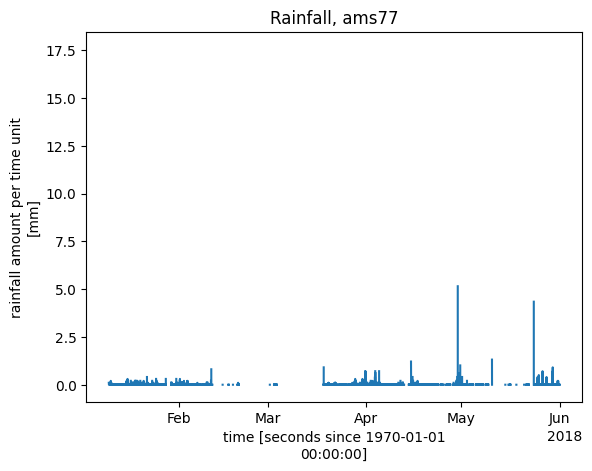

In [12]:
ds_pws.rainfall.sel(id="ams77").plot.line(x="time", add_legend=True)
plt.title("Rainfall, " + str(ds_pws.id.sel(id=stations).data))

Let us now look at two stations with a lot of -1, meaning that the FZ filter cannot be applied. We can suspect that this means that the stations have less than `n_stat` neighbours.

Text(0.5, 1.0, "Faulty Zero Flags, ['ams4' 'ams5']")

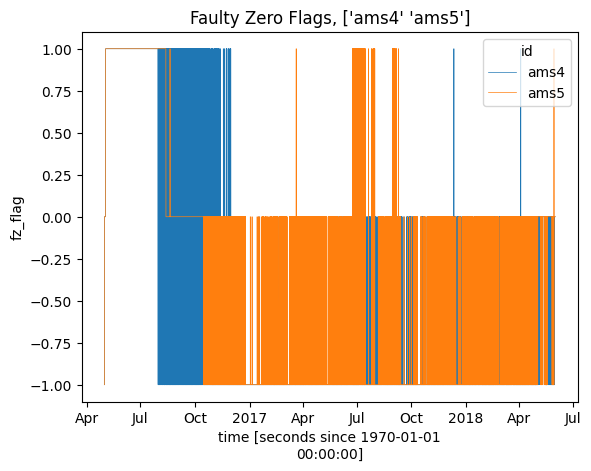

In [13]:
stations = ["ams4", "ams5"]
plt.figure()
ds_pws.fz_flag.sel(id=stations).plot.line(x="time", add_legend=True, linewidth=0.5)
plt.title("Faulty Zero Flags, " + str(ds_pws.id.sel(id=stations).data))

Indeed, when plotting the number of neighbours we see that they drop below the `n_stat` threshold (in this case 5 neighbours) in early August and October, respectively. ams4 fluctuate around 5 neighbours for a 3-month period.

Text(0.5, 1.0, "Neighbouring stations per time step, ['ams4' 'ams5']")

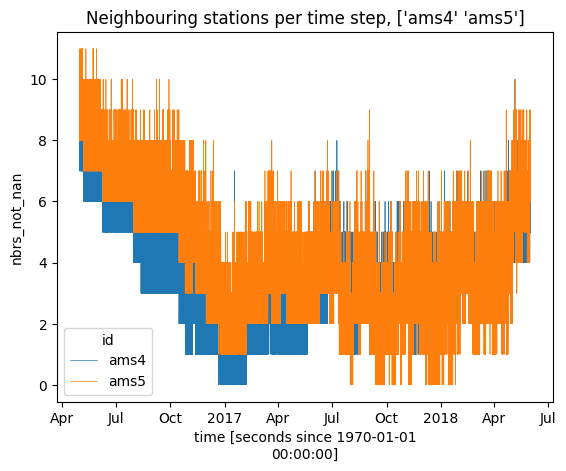

In [14]:
stations = ["ams4", "ams5"]
plt.figure()
ds_pws.nbrs_not_nan.sel(id=stations).plot.line(x="time", add_legend=True, linewidth=0.5)
plt.title(
    "Neighbouring stations per time step, " + str(ds_pws.id.sel(id=stations).data)
)

### Apply High Influx filter

Conditions for raising High Influx flag:

* If median below threshold `ϕA`, then high influx if rainfall above threshold `ϕB`
* If median above `ϕA`, then high influx if rainfall exceeds median times `ϕB`/`ϕA`
* Filter cannot be applied if less than `nstat` neighbours are reporting data (HI flag is set to -1)

For settings for parameter `ϕA`, `ϕB` and `nstat`, see table 1 in https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL083731

In [15]:
hi_flag = pypwsqc.flagging.hi_filter(
    pws_data=ds_pws.rainfall,
    nbrs_not_nan=ds_pws.nbrs_not_nan,
    reference=ds_pws.reference,
    hi_thres_a=0.4,
    hi_thres_b=10,
    n_stat=5,
)

#### Add HI flags to data set

In [16]:
ds_pws["hi_flag"] = hi_flag

#### Save output

In [17]:
# add conoding to compress the file
encoding = {
    "rainfall": {
        "dtype": "int32",
        "scale_factor": 0.001,
        "zlib": True,
        "_FillValue": -9999,
        "complevel": 3,
    }
}

In [18]:
save_path = "data/"

# write the xarray dataset to netCDF file
# ds_pws.to_netcdf(save_path + "OpenSense_PWS_data_FZ_HI_flags.nc",
#             encoding=encoding)

## Inspect some results 

Station ams44 get some HI flags, while the neighbors ams45 and ams46 do not

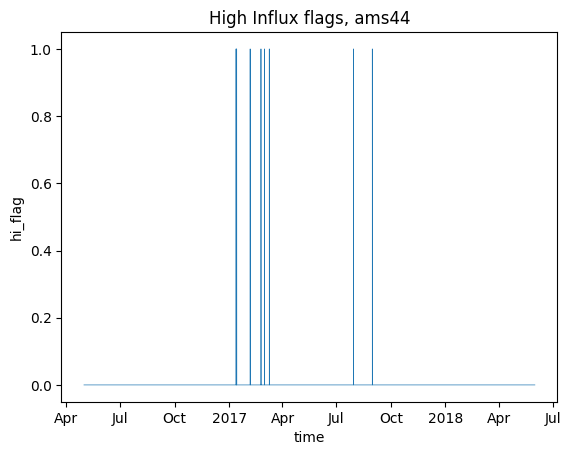

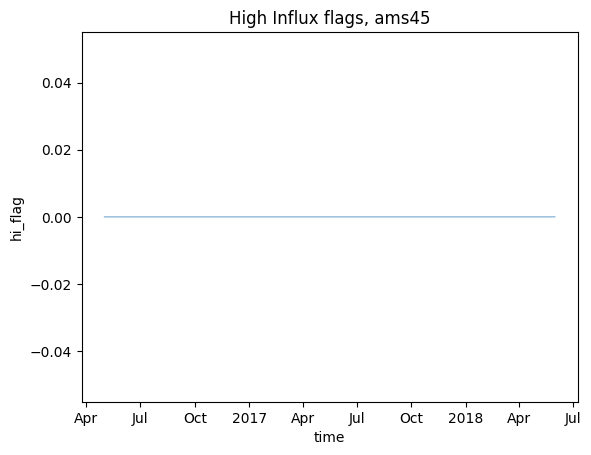

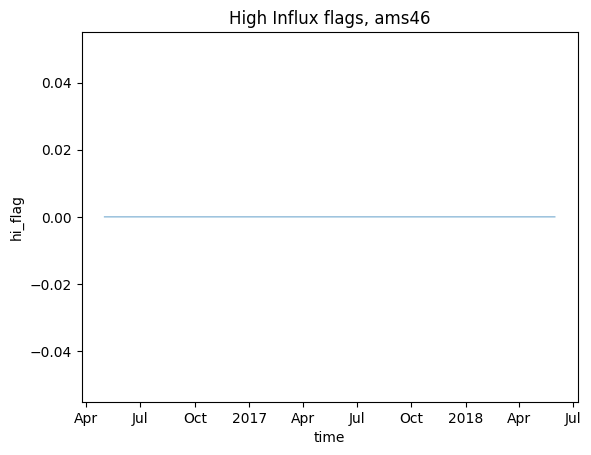

In [19]:
stations = ["ams44", "ams45", "ams46"]
for station in stations:
    plt.figure()
    ds_pws.hi_flag.sel(id=station).plot.line(x="time", add_legend=True, linewidth=0.5)
    plt.title("High Influx flags, " + str(ds_pws.id.sel(id=station).data))

Let us therefore inspect the rainfall time series of these stations. 

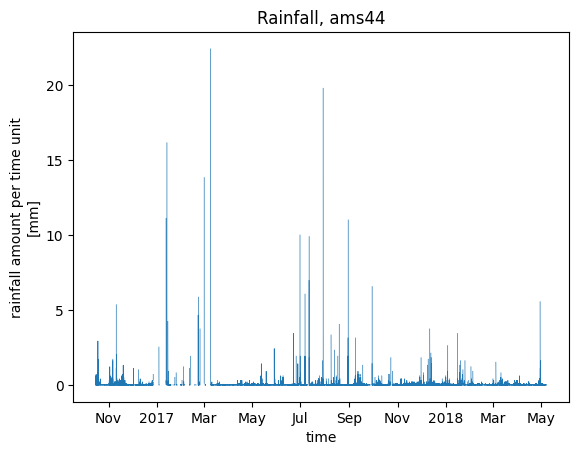

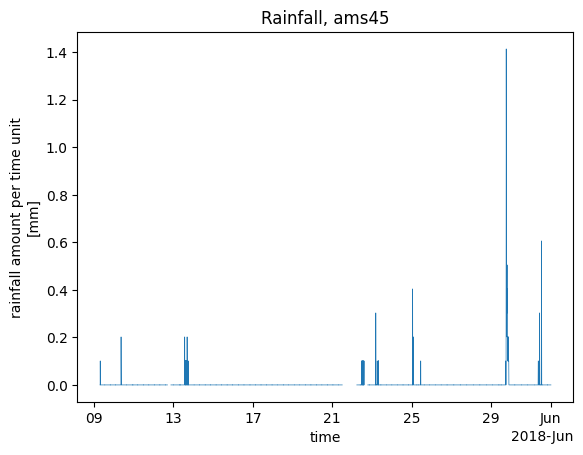

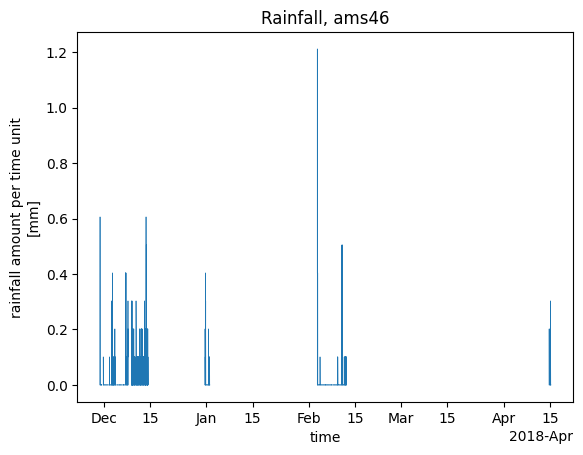

In [20]:
stations = ["ams44", "ams45", "ams46"]
for station in stations:
    plt.figure()
    ds_pws.rainfall.sel(id=station).plot.line(x="time", add_legend=True, linewidth=0.5)
    plt.title("Rainfall, " + str(ds_pws.id.sel(id=station).data))

The rainfall time series of ams45 and ams46 look suspicious. Let us check the FZ flags of these two stations.

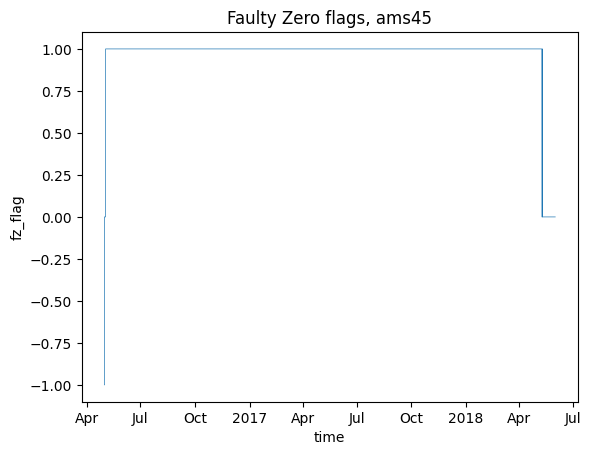

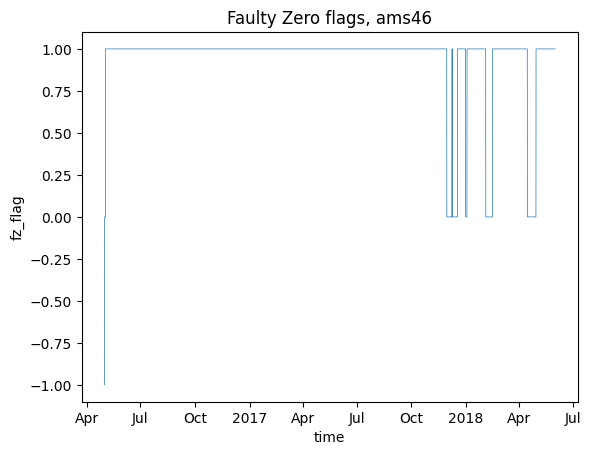

In [21]:
stations = ["ams45", "ams46"]
for station in stations:
    plt.figure()
    ds_pws.fz_flag.sel(id=station).plot.line(x="time", add_legend=True, linewidth=0.5)
    plt.title("Faulty Zero flags, " + str(ds_pws.id.sel(id=station).data))

Ams45 and ams46 do indeed report faulty zeros through most of the period, which potentially could explain why ams44 is reporting high influxes.